# Recherche d'Information et traitement de données massives

# Lab 1 : Indexation : représentation d'un document et d'un corpus


L'objectif de cette séance est de mettre en oeuvre les premiers concepts clés de la **Recherche d'Information** que sont l'indexation et l'index inversé. Nous travaillerons sur la collection [TIME](http://ir.dcs.gla.ac.uk/resources/test_collections/time/). Cette collection est une petite collection qui est constituée d'articles du magazine TIME et qui est disponible dans le repertoire [Data](./Data/Time). Plus précisemment, cette collection est constituée des fichiers suivants :
+ Le fichier [TIME.ALL](./Data/Time/TIME.ALL) qui contient l'ensemble des articles sous la forme d'un seul fichier texte. Chaque article est identifié dans le fichier par une chaine de caractères du type `*TEXT XXX PAGE XXX`. Le fichier commence avec la chaîne de caractères `*TEXT 017 01/04/63 PAGE 020` et le dernier article correspond à la chaine de caractères `*TEXT 563 12/27/63 PAGE 024`. Le chaîne de caractères `*STOP` indique  la fin du fichier. La collection contient en tout 423 articles. Dans la suite, les documents seront identifiés par un identifiant unique qui est le numero présent dans la chaîne `*TEXT XXX PAGE XXX`. Par exemple, l'article préfixé par `*TEXT 563 12/27/63 PAGE 024` aura comme identifiant `563`
+ Le fichier [TIME.QUE](./Data/Time/TIME.QUE) qui contient un ensemble de requêtes exprimées en langage naturel. Chaque requête est identifiée dans le fichier par la chaîne de caractères ` *FIND      ID`
+ Le fichier [TIME.REL](./Data/Time/TIME.REL) qui contient les jugements de pertinence exaustifs pour chaque requête. Par exemple la ligne `1  268 288 304 308 323 326 334` doit être interprétée de la manière suivante : les documents pertinents de la collection pour la requête `1` sont les documents `268 288 304 308 323 32` et `334` 
+ Le fichier [TIME.STP](./Data/Time/TIME.STP) est une liste des stop-words à considérer dans cette collection.



### Etape 1 : Prise en main des données

Dans un premier temps, le travail consistera en une prise en main des données. En particulier, il s'agira de lire le fichier [TIME.ALL](./Data/Time/TIME.ALL) et de stocker la collection sous la forme d'un dictionnaire python (`dict`) avec comme **clé** l'identifiant unique de chaque article et en **valeur** une liste (`list`) des tokens de chaque article. Pour l'étape de segmentation (ou *tokenization*), on considerera les espaces et les caractères de ponctuation comme séparateurs et on fera appel à la bibliothèque [nltk](https://www.nltk.org) et en particulier à son module [tokenize](https://www.nltk.org/api/nltk.tokenize.html). La commande ci-dessous vous permet d'installer cette bibliothèque.

In [1]:
!pip install nltk

Importer la bibliothèque nltk et télécharger les jeux de données et modules nécéssaires pour le traitement du langage naturel en executant les deux commandes ci-dessous. 

In [3]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

#### Lecture des données

Ecrire une fonction `loadData(filename)` qui charge le fichier [TIME.ALL](./Data/Time/TIME.ALL), stocke et retourne son contenu sous la forme d'un dictionnaire python (`dict`) avec comme **clé** l'identifiant unique de chaque article et en **valeur** le contenu de l'article sous la forme d'une chaine de caractères. Pour rappel, nous prendrons comme identifiant le numéro indiqué dans le fichier. 

Par exemple, l'article préfixé par `*TEXT 563 12/27/63 PAGE 024` aura comme identifiant `563`. Il y a parfois des trous dans la numérotation. 

Pour faire cela, il vous faudra donc parser votre fichier en prenant en compte sa structure décrite ci-dessous. Vous pourrez par exemple utiliser des [expressions régulières](https://docs.python.org/3/library/re.html) pour détecter la fin du corpus ou le début d'un nouvel article. Une bon tutoriel concernant les expressions régulières est disponible [ici](https://www.xavierdupre.fr/app/teachpyx/helpsphinx/c_regex/regex.html). 


In [64]:
import re

def loadData(filename):
    with open(filename, 'r') as f:
        corpus = {}
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            line = line.split()
            if '*TEXT' in line:
                key = line[1]
                #print(key)
            else:
                if line != [] and ('*STOP' not in line):
                    if key in corpus:
                        corpus[key] += ' '.join(line)
                    else:
                        corpus[key] = ' '.join(line)
        return(corpus)
    
    

Appliquer et tester votre fonction au fichier [TIME.ALL](./Data/Time/TIME.ALL) en executant le code ci-dessous.

In [65]:
corpus = loadData('./Data/Time/TIME.ALL')

In [68]:
corpus = loadData('./Data/Time/TIME.ALL')

print(corpus['563'] == 'UNITED NATIONS POTENT PYGMY IN MANHATTAN LAST WEEK, THE U.N .GREW TO A TOTAL OF 113 MEMBERS WITH THE ADMISSION OF THE NEWLYINDEPENDENT STATES OF ZANZIBAR AND KENYA . ZANZIBAR CONSISTS OF TWOSMALL ISLANDS IN THE INDIAN OCEAN, WITH A TOTAL POPULATION OF 310,000,OR ABOUT THAT OF OMAHA . NEVERTHELESS, ZANZIBAR HAS ONE VOTE IN THEGENERAL ASSEMBLY, AND IS THUS EQUAL IN VOTING POWER WITH SUCH NUCLEARGIANTS AS THE SOVIET UNION AND THE U.S .')

True


### Etape 2 : extraction du vocabulaire d'indexation.

Dans cette étape, vous allez mettre en oeuvre la chaîne de traitements vue dans le cours 1 et rappelée sur la figure ci-dessous.

<img src="./Images/indexationschema.png" width="500" height="500" />

Il s'agira donc de mettre en oeuvre les étapes suivantes :
   + 1. Segmentation d'un texte en mots (étape de tokenization).
   + 2. Filtrage des mots vides.
   + 3. Lemmatisation ou Racinisation des termes.
   + 4. Extraction des mots uniques

**Différentes approches seront testées pour plusieurs de ces étapes.**


#### 1 . Segmentation d'un texte en mots

Vous allez maintenant écrire un programme permettant de segmenter un article en mots ou tokens. On considèrera que l'article est fourni sous la forme d'une chaîne de caractères `text`. On testera ici différentes approches de segmentation dont :
 + une approche simple avec la méthode [`split()`](https://www.w3schools.com/python/ref_string_split.asp) de python.
 + l'approche de segmentation en mots avec la fonction [`word_tokenize()`](https://pythonspot.com/tokenizing-words-and-sentences-with-nltk/) de la bibliothèque nltk.
 + une autre approche de segmentation que vous choisirez parmi les approches disponibles dans la bibliothèque [ntlk](https://www.nltk.org/api/nltk.tokenize.html). Par exemple, le `RegexpTokenizer` qui se base sur les expressions régulières peut être intéressant pour détecter les dates ou nombres dans les articles.

Dans tous les cas, vos fonctions `article_tokenize_simple(text)`, `article_word_tokenize(text)` et `article_tokenize_other(text)`prendront en paramètres une chaine de caractères `text` et retourneront la liste des mots (ou *tokens*) de la chaîne `text`.

Nous considérerons qu'une bonne segmentation :
 + ne considérera pas les caractères de ponctuations comme des mots;
 + permettra de récupérer les dates ou les chiffres;
 + permettra de garder les abbréviations d'interêt type `U.S`.


Selon la méthode de segmentation utilisée, l'amélioration de la segmentation pourra être fait a posteriori par exemple avec du filtrage.

**Approche de segmentation simple**

In [73]:
(['a' ] or ['b']) in ['a']

False

In [74]:
def article_tokenize_simple(text):
    if type(text)!= str:
        raise Exception("The function takes a string as input data")
    else:
        ignore = ['.']
        text = text.split()
        tokens = []
        for word in text:
            if word not in ignore:
                tokens.append(word)
        tokens = list(set(tokens))
        return tokens
        

Tester votre méthode sur l'article donné ci-dessous.

In [75]:
text = 'UNITED NATIONS POTENT PYGMY IN MANHATTAN LAST WEEK, THE U.N .GREW TO A TOTAL OF 113 MEMBERS WITH THE ADMISSION OF THE NEWLYINDEPENDENT STATES OF ZANZIBAR AND KENYA . ZANZIBAR CONSISTS OF TWOSMALL ISLANDS IN THE INDIAN OCEAN, WITH A TOTAL POPULATION OF 310,000,OR ABOUT THAT OF OMAHA . NEVERTHELESS, ZANZIBAR HAS ONE VOTE IN THEGENERAL ASSEMBLY, AND IS THUS EQUAL IN VOTING POWER WITH SUCH NUCLEARGIANTS AS THE SOVIET UNION AND THE U.S .'
 
article_tokenize_simple(text)

['VOTING',
 'STATES',
 'KENYA',
 'UNION',
 'U.N',
 'ASSEMBLY,',
 'LAST',
 'UNITED',
 'A',
 'THAT',
 'TWOSMALL',
 'AS',
 'NUCLEARGIANTS',
 'ABOUT',
 'SUCH',
 '113',
 'IN',
 'MANHATTAN',
 'ISLANDS',
 'NEWLYINDEPENDENT',
 'ONE',
 'IS',
 'EQUAL',
 'THEGENERAL',
 '310,000,OR',
 'CONSISTS',
 'U.S',
 'WITH',
 'POTENT',
 'AND',
 'OMAHA',
 'THE',
 'POWER',
 'VOTE',
 'TO',
 'OF',
 '.GREW',
 'POPULATION',
 'SOVIET',
 'PYGMY',
 'TOTAL',
 'NATIONS',
 'ADMISSION',
 'MEMBERS',
 'INDIAN',
 'ZANZIBAR',
 'OCEAN,',
 'HAS',
 'WEEK,',
 'THUS',
 'NEVERTHELESS,']

**Approche de segmentation avec avec la fonction `word_tokenize()`**

In [76]:
from nltk.tokenize import word_tokenize

def article_word_tokenize(text):
    if type(text)!= str:
        raise Exception("The function takes a string as input data")
    else:
        tokens = word_tokenize(text)
        return tokens


Tester votre méthode sur l'article donné ci-dessous.

In [77]:
text = 'UNITED NATIONS POTENT PYGMY IN MANHATTAN LAST WEEK, THE U.N .GREW TO A TOTAL OF 113 MEMBERS WITH THE ADMISSION OF THE NEWLYINDEPENDENT STATES OF ZANZIBAR AND KENYA . ZANZIBAR CONSISTS OF TWOSMALL ISLANDS IN THE INDIAN OCEAN, WITH A TOTAL POPULATION OF 310,000,OR ABOUT THAT OF OMAHA . NEVERTHELESS, ZANZIBAR HAS ONE VOTE IN THEGENERAL ASSEMBLY, AND IS THUS EQUAL IN VOTING POWER WITH SUCH NUCLEARGIANTS AS THE SOVIET UNION AND THE U.S .'
 
article_word_tokenize(text)

['UNITED',
 'NATIONS',
 'POTENT',
 'PYGMY',
 'IN',
 'MANHATTAN',
 'LAST',
 'WEEK',
 ',',
 'THE',
 'U.N',
 '.GREW',
 'TO',
 'A',
 'TOTAL',
 'OF',
 '113',
 'MEMBERS',
 'WITH',
 'THE',
 'ADMISSION',
 'OF',
 'THE',
 'NEWLYINDEPENDENT',
 'STATES',
 'OF',
 'ZANZIBAR',
 'AND',
 'KENYA',
 '.',
 'ZANZIBAR',
 'CONSISTS',
 'OF',
 'TWOSMALL',
 'ISLANDS',
 'IN',
 'THE',
 'INDIAN',
 'OCEAN',
 ',',
 'WITH',
 'A',
 'TOTAL',
 'POPULATION',
 'OF',
 '310,000',
 ',',
 'OR',
 'ABOUT',
 'THAT',
 'OF',
 'OMAHA',
 '.',
 'NEVERTHELESS',
 ',',
 'ZANZIBAR',
 'HAS',
 'ONE',
 'VOTE',
 'IN',
 'THEGENERAL',
 'ASSEMBLY',
 ',',
 'AND',
 'IS',
 'THUS',
 'EQUAL',
 'IN',
 'VOTING',
 'POWER',
 'WITH',
 'SUCH',
 'NUCLEARGIANTS',
 'AS',
 'THE',
 'SOVIET',
 'UNION',
 'AND',
 'THE',
 'U.S',
 '.']

**Approche de segmentation de votre choix**

In [ ]:
def article_tokenize_other(text):
    if type(text)!= str:
        raise Exception("The function takes a string as input data")
    else:
        # A COMPLETER
        return tokens

Tester votre méthode sur l'article donné ci-dessous.

In [15]:
text = 'UNITED NATIONS POTENT PYGMY IN MANHATTAN LAST WEEK, THE U.N .GREW TO A TOTAL OF 113 MEMBERS WITH THE ADMISSION OF THE NEWLYINDEPENDENT STATES OF ZANZIBAR AND KENYA . ZANZIBAR CONSISTS OF TWOSMALL ISLANDS IN THE INDIAN OCEAN, WITH A TOTAL POPULATION OF 310,000,OR ABOUT THAT OF OMAHA . NEVERTHELESS, ZANZIBAR HAS ONE VOTE IN THEGENERAL ASSEMBLY, AND IS THUS EQUAL IN VOTING POWER WITH SUCH NUCLEARGIANTS AS THE SOVIET UNION AND THE U.S .'
 
# A completer

**Segmentation de l'ensemble du corpus en mots**

En appliquant vos différentes fonctions de segmentation sur différents exemples, vous devriez pouvoir effectuer une comparaison qualitative des différentes approches de segmentation et ainsi choisir la méthode de segmentation la plus appropriée pour le corpus TIME. 
Appliquer ensuite la méthode choisie à l'ensemble des documents du corpus.


In [20]:
# a completer



#### 2 . Filtrage des mots vides

Ecrivez une fonction `article_remove_stop_words(text_tokens,stop_word_file)` qui prend en paramètres une liste de tokens, qui supprime les mots vides fournis dans un fichier de cette liste et renvoie la nouvelle liste résultant de ce filtrage. On procédera ici aussi de deux manière :
 + Dans une première approche, vous prendrez les mots vides fournis avec la collection dans le fichier [TIME.STP](./Data/TIME.STP).
 + Dans une deuxième approche, vous constituerez vous même votre liste de mots vides en prenant par exemples les n=200 mots les plus fréquents de la collection. Vous pourrez vous même décider d'un bon choix de n.
 


In [79]:
def article_remove_stop_words(text_tokens,stop_word_file):
    tokens = []
    for word in text_tokens:
        if word not in stop_word_file:
            tokens.append(word)
    return tokens

**Approche 1 : creation d'une liste de mots vides en étudiant la fréquence des mots**

Ecrivez une fonction qui permet de compter le nombre d'occurences de chaque token dans la collection. Vous pouvez pour cela, mais sans obligation, faire appel à la collection [`Counter`](https://pymotw.com/2/collections/counter.html) de la bibliothèque standard de python qui permet de compter le nombre d'occurences des éléments d'une collection et donc l'interface est très proche de celle des dictionnaires.


In [21]:
def count_frequency(collection):
    tokens_count = Counter()
    return tokens_count
      

Selectionner les n tokens les plus fréquents dans la collection et sauvegarder les dans une liste que l'on considèrera dans la suite comme une liste de mots-vides.

In [ ]:
# A completer

Visualiser sous la forme d'un histogramme les 25 tokens les plus fréquents de la collection. On utilisera pour cela les bibiothèques [matplolib](https://matplotlib.org/) et [seaborn](https://seaborn.pydata.org/) qu'il vous faudra installer (si pas déja le cas) et importer au préalable. Le code ci-dessous vous montre un exemple de code qui affiche un histogramme de manière horizontale des 30 éléments les plus fréquents d'une collection de type `Counter` et que vous pouvez réutiliser, en l'adaptant, pour répondre à la question demandée. L'exemple est donné sur un article et non sur un  corpus.

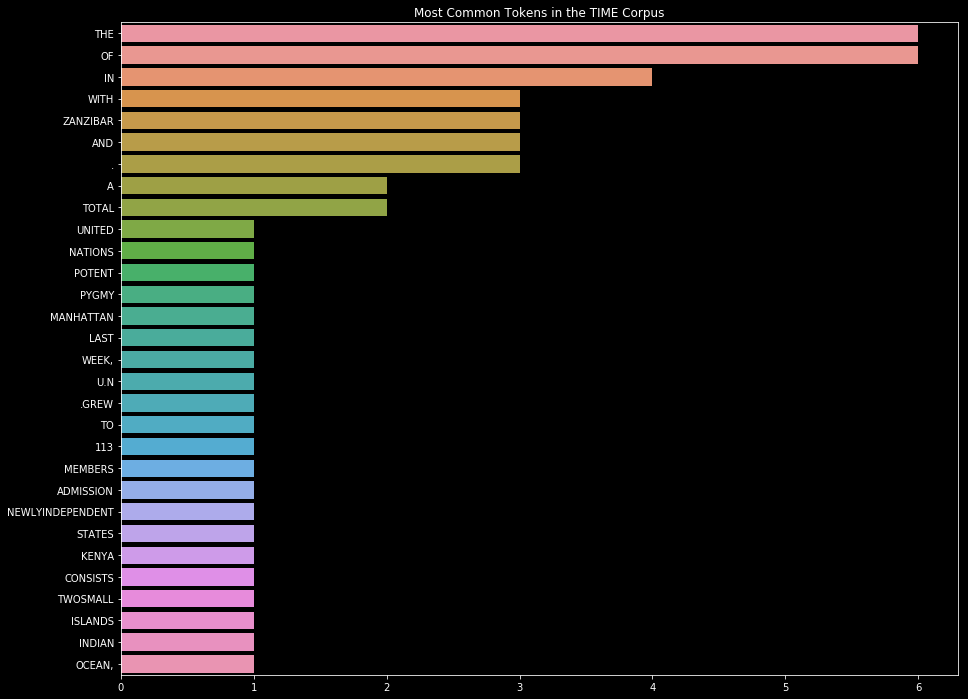

In [24]:
%matplotlib inline
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

text = 'UNITED NATIONS POTENT PYGMY IN MANHATTAN LAST WEEK, THE U.N .GREW TO A TOTAL OF 113 MEMBERS WITH THE ADMISSION OF THE NEWLYINDEPENDENT STATES OF ZANZIBAR AND KENYA . ZANZIBAR CONSISTS OF TWOSMALL ISLANDS IN THE INDIAN OCEAN, WITH A TOTAL POPULATION OF 310,000,OR ABOUT THAT OF OMAHA . NEVERTHELESS, ZANZIBAR HAS ONE VOTE IN THEGENERAL ASSEMBLY, AND IS THUS EQUAL IN VOTING POWER WITH SUCH NUCLEARGIANTS AS THE SOVIET UNION AND THE U.S .'
tokens = text.split()
count_tokens = collections.Counter(tokens)

corpus_common_words = [word[0] for word in count_tokens.most_common(30)]
corpus_common_counts = [word[1] for word in count_tokens.most_common(30)]

plt.style.use('dark_background')
plt.figure(figsize=(15, 12))


sns.barplot(x=corpus_common_counts,y=corpus_common_words)
plt.title('Most Common Tokens in the TIME Corpus');

In [ ]:
# A completer : code pour visualiser les n tokens les plus frequents de la collection

Ecrire un programme permettant de comparer la liste obtenue avec les mots fréquents et la liste de mots vides fournie dans le fichier [TIME.STP](./Data/TIME.STP). Il vous faudra bien sûr d'abord charger le fichier.

In [ ]:
# A completer : comparaison des deux listes de mots vides.

Ecrire une fonction `remove_stop_words` qui prend une collection segmentée en entrée et qui renvoie la collection segmentée et filtrée (c'est à dire sous la forme d'un ensemble de documents segmentés et privés des mots vides). Pour rappel, dans ce TP, nous utilisons une représentation de la collection sous la forme d'un dictionnaire dont les clés sont les identifiants uniques des documents (`doc_id`) et les valeurs sont une liste des mots ou tokens du document. Nous pouvons travailler avec ce type de représentation car notre collection est de petite taille. 

In [0]:
def remove_stop_words(collection ,stop_word_file):
    # TO COMPLETE
    return 
    


Appliquer la fonction précédente avec les deux listes de mots vides proposées (liste des n mots les plus fréquents et liste des mots vide

In [ ]:
# A completer : application des opérations de filtrage à la collection TIME

Comparer les collections segmentées ainsi obtenues par exemple en comparant la taille (en nombre de tokens) après application des différentes étapes de filtrage.

In [ ]:
# A completer : comparaison des méthodes de filtrage

Visualiser maintenant, toujours sous la forme d'un histogramme les 25 tokens les plus fréquents de la collection.

#### 3 . Normalisation des termes

Il s'agit ici d'écrire les fonctions permettant d'apppliquer les étapes de normalisation (lemmatisation et racinisation) vues en cours et qui permettent de réduire la taille du vocabulaire. Pour rappel, cette étape consiste à représenter les mots par leur forme canonique ou leur racine afin de ne conserver que le sens des mots utilisés et de reduire ainsi la taille du vocabulaire de représentation. Ces opérations sont souvent assez complexes et nous allons pour cela utiliser les fonctions du package [`stem`](https://www.nltk.org/api/nltk.stem.html) de nltk.

**Racinisation**

Pour la racinisation, nous allons utiliser l'algorithme de Porter mentionné en cours et dont une implémentation est fournie dans le package `stem`. Compléter le code ci-dessous pour appliquer l'algorithme de Porter à votre collection. Attention, la fonction `stem` s'applique sur un mot ou token donné.


In [30]:
from nltk.stem import PorterStemmer

def collection_stemming(segmented_collection):
    stemmer = PorterStemmer () # initialisation d'un stemmer
    # a completer
    return stemmed_collection

# test sur la collection TIME filtrée des mots vides

# a completer



**Lemmatisation**

Pour la lemmatisation, nous allons utiliser le `WordNetLemmatizer` du package `stem` de nltk. Comme précedemment, complèter le code ci-dessous pour l'appliquer à votre collection segmentée et privée des mots vides.

In [31]:
from nltk.stem import WordNetLemmatizer

def collection_lemmatize(segmented_collection):
    stemmer = WordNetLemmatizer () # initialisation d'un lemmatiseur
    # a completer
    return lemmatized_collection

# test sur la collection TIME filtrée des mots vides

# a completer

Prenez le temps d'observer le résultat de ces opérations sur les mots de la collection TIME pour vous faire une idée sur l'impact que ces opérations peuvent avoir sur le processus d'indexation et de recherche.

#### 4 . Extraction du vocabulaire

Nous arrivons maintenant à la dernière étape de cette chaîne de traitements linguistiques qui consiste à extraire le vocabulaire de termes résultant de cette suite de traitements. C'est une étape assez simple à mettre en oeuvre (c.f. travail précédent sur la fréquence des mots). Ici, nous cherchons les termes uniques et nous pouvons donc utiliser le type [`set`](https://docs.python.org/3/tutorial/datastructures.html#sets) prédéfini dans python et qui est une collection non-ordonnée d’objets uniques et immuables. 
Le code ci-dessous vous montre un exemple d'utilisation de cette struture de données.

In [32]:
a = set()
a.update(['bon'])
a.update(['sur'])
a.update(['au'])
a.update(['sur'])
a

{'au', 'bon', 'sur'}

Completer le code ci-dessous permettant de construire le vocabulaire de termes d'index de votre collection.

In [33]:
def extract_indexation_vocabulary(processed_collection):
    vocabulary = set()
    # a completer
    return vocabulary

### Etape 3 : étude des lois de puissance du corpus.

Vous allez ici nous intéresser à des informations statistiques sur votre corpus. Il faudra en particulier répondre aux différentes questions ci-dessous.


#### Question 1 : Quel est le nombre de tokens dans le corpus ? 

Ecrire une fonction `count_tokens (collection)` permettant de compter le nombre de tokens dans votre collection. Vous pourrez par exemple comparer le nombre de tokens obtenus pour chacune des méthodes de segmentation implémentée précedemment.

In [34]:
# a completer

#### Question 2 : Quel est la taille du vocabulaire obtenu par l'application des traitements de l'étape 2 sur votre collection ?

Ecrire une fonction `count_terms(collection)` permettant de compter le nombre de termes uniques obtenus après l'application des traitements de l'étape 2 sur la collection complète. Vous pourrez notamment mesurer l'impact des différentes étapes sur la taille du vocabulaire final en comparant les tailles obtenues à chaque étape.

In [35]:
# à compléter 

#### Question 3 : Estimation sur la moitié de la collection ?
    
Calculer le nombre total de tokens et la taille du vocabulaire pour la moitié de la collection (211 premiers articles) et utiliser les résultats avec les deux précédents pour déterminer les paramètres k et b de la loi de Heap (c.f. cours 1). 

In [36]:
# à compléter 

#### Question 4 : Et pour 1 million de tokens  ?

Estimer la taille du vocabulaire pour une collection de 1 million de tokens pour votre collection.

#### Question 5 : Loi de Zipf

Tracer le graphe fréquence (f) vs rang (r) pour tous les tokens de la collection. Tracer
aussi le graphe log(f) vs log(r).

In [37]:
# à compléter 

### Etape 4 : Construction de l'index inversé

Nous avons maintenant tous les ingrédients nécessaires pour construire l'index inversé de la collection. Pour rappel, l'index inversé est une structure de données, fondamentale en recherche d'information, permettant de stocker l'information utile sous la forme d'un dictionnaire de termes dont la clé est un tuple forme du terme lui-même et sa fréquence dans la collection (au sens `df`: nombre de documents dans lesquels le terme apparaît au moins une fois) et dont la valeut est une liste qui enregistre à minima les numéros des documents dans lesquels le terme apparait.


<img src="./Images/iindex.png" width="500" height="500" />

Pour la collection TIME, l'algorithme ci-dessous peut être utilisé pour construire cet index.


<img src="./Images/algorithm.png" width="500" height="500" />

Completer la fonction `build_inverted_index(collection,type_index)` ci-dessous qui permet de construire l'index inversé d'une collection donnée en paramètre. Le paramètre `type_index` vous permettra de préciser le type d'index à construire parmi les 3 vus en cours : index de documents (type = 1), index de fréquence (type = 2) et index de position (type =3). L

In [38]:
def build_invertes_index(collection,type_index):
    # à complèter
    return inverted_index
    
    

#### Sauvegarde de l'index inversé dans un fichier 

Il nous reste maintenant à sauvegarder l'index créé sous la forme d'un fichier texte selon le format ci-dessous :
```
Term1, df_1 | (doc_1, tf_doc1_Term1) (doc_4, tf_doc_4_Term1)
Term2, df_2 | (doc_3, tf_doc3_Term2) 
...
```

Pour un index de position, le format sera le suivant :
```
Term1, df_1 | (doc_1, tf_doc1_Term1 ; pos1 pos2 ... posn) (doc_4, tf_doc_4_Term1; pos1 pos2 )
Term2, df_2 | (doc_3, tf_doc3_Term2 ; pos1 pos2 ..posm) 
...
```
Ecrire une fonction permettant de sauvegarder votre index inversé sur disque sous la forme d'un fichier texte


In [39]:
# A compléter

#### Chargement d'un index inversé

Ecrire une fonction permettant de charger un index inversé sauvegardé sous la forme d'un fichier texte comme un dictionnaire.

In [40]:
# A compléter

#### Taille et temps de construction de l'index

Il s'agit ici de répondre aux questions suivantes :
+ Quelle est la taille de l'index inversé obtenu en mémoire ? (indice : utilisation de `getsizeof`du module sys)
+ Quelle est la taille de l'index inversé écrit sur disque ?
+ Combien de temps prend la construction de votre index en tout (indice : utilisation du module `time`)?


In [41]:
# A compléter